<a href="https://colab.research.google.com/github/blueberrycrumble/AIFFEL_quest_cr/blob/master/MainQuest/Quest02/pokemon_MainQuest02_20250207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

메인퀘스트 02. 전설의 포켓몬 찾기  
데이터셋: https://www.kaggle.com/datasets/abcsds/pokemon  

[x] Flow chart  
[x] Data preprocessing  
[x] Baseline Model Training  
[x] Comparison and Analysis  
[x] Report  

# STEP 0. Planning

### Flow Chart

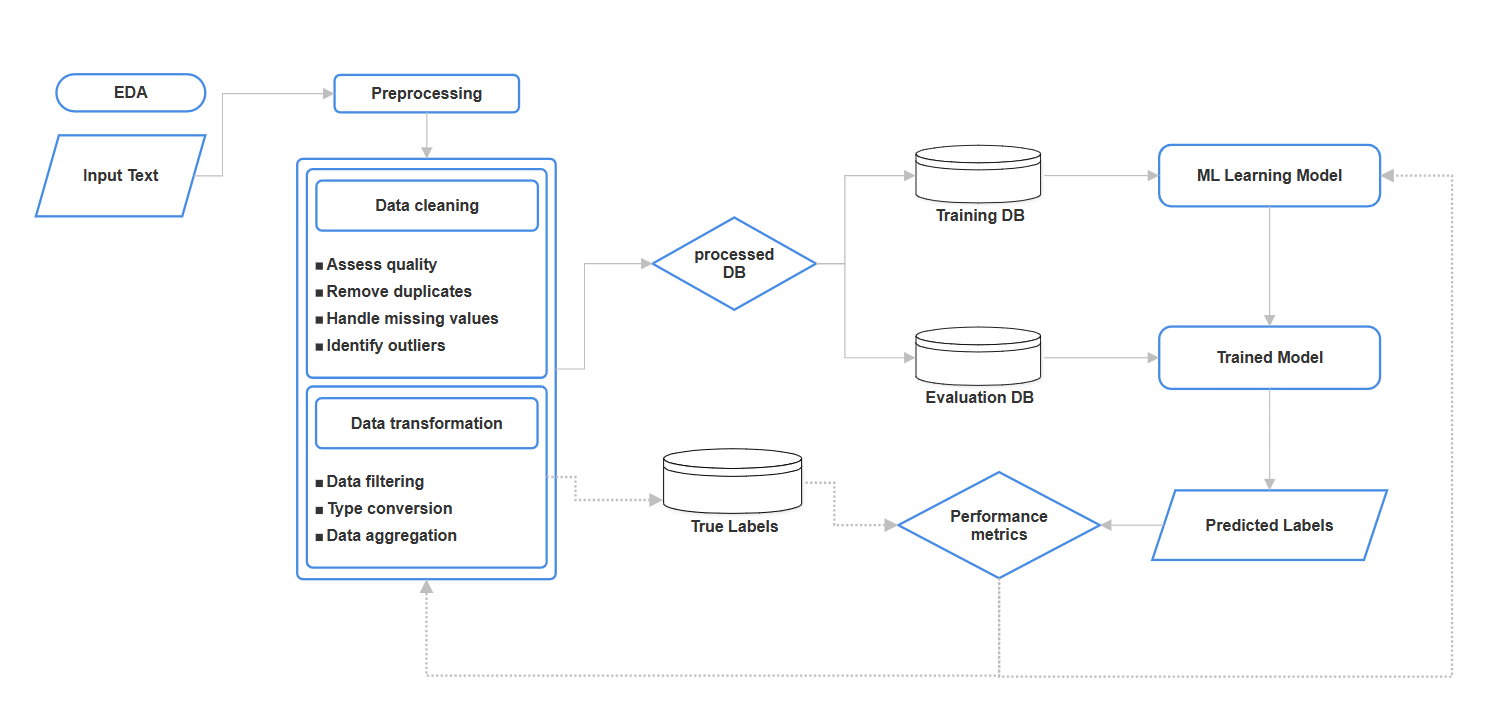

### 진행 단계

1. EDA 탐색적 데이터 분석  
    - 분석 목적 파악
    - 목적에 부합하는 기준치 설정
    - 특성 종류와 특징 파악
    - 데이터 분포도 파악
    - 결측치, 이상치 파악
2. Data preprocessing  
    - 결측치, 이상치 처리
    - 범주형 데이터 처리
    - feature engineering
    - 데이터 분포 변환 (밸런스 맞추기)
3. Baseline Model Training  
    - 모델링
    - 훈련
4. Comparison and Analysis  
    - 검증, 테스트
    - 하이퍼 파라미터 튜닝, 피쳐 엔지니어링
5. Report  
    - 프로젝트 평가
    - 회고
    - 주석 및 의견
    - 회고
    - 레퍼런스

# STEP 1. EDA

### 변수 리스트와 라이브러리

In [ ]:
'''
Variable Names

pokemon --copied datasets
legendary --
ordinary --
types --


'''

In [ ]:
# Download the datasets from Kaggle
# !pip install kagglehub --upgrade
import kagglehub
path = kagglehub.dataset_download("abcsds/pokemon")
print("Path to dataset files:",path)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# step4. 다른 분류기와 지표 사용
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb


# OrderedDict, Counter 등의 모듈을 제공하는 파이썬의 패키지
from collections import Counter

# seaborn은 독립적으로 사용할 수 있으나, 그래프 조정이나 세부 설정을 위해 matplotlib 함께 사용
# 예) plt.show()를 명시적으로 호출하거나, plt.figure()를 함께 사용할 때
import matplotlib.pyplot as plt

# 주피터 노트북 환경에서 그래프를 바로 출력하도록 설정
%matplotlib inline
# 주피터 노트북 환경에서 그래프를 고해상도로 출력
%config inlineBackend.figure_format = 'retina'

### 데이터셋의 크기와 구성



In [ ]:
# load dataset
original_data = pd.read_csv(path+'/Pokemon.csv')
# copy dataset
pokemon = original_data.copy()

print(pokemon.shape)
pokemon.head(10)

---
데이터셋의 크기
- 포켓몬 샘플 800개
- 각 포켓몬의 특성 13종
---  
[노드 1-5]  
각 특성의 정보는 다음과 같다.

    - #: ID for each pokemon (성별이 다르지만 같은 포켓몬인 경우 등은 같은 #값을 가진다.)
    - Name: Name of each pokemon  
    - Type 1: Each pokemon has a type, this determines weakness/resistance to attacks  
    - Type 2: Some pokemon are dual type and have 2  
    - Total: sum of all stats that come after this, a general guide to how strong a pokemon is  
    - HP: hit points, or health, defines how much damage a pokemon can withstand before fainting  
    - Attack: the base modifier for normal attacks (eg. Scratch, Punch)  
    - Defense: the base damage resistance against normal attacks  
    - SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)  
    - SP Def: the base damage resistance against special attacks  
    - Speed: determines which pokemon attacks first each round   

---
타겟 설정
- Legendary 여부를 True/False 로 판별한다．
- True 값은 `lengendary` 변수에 저장
- False 값은 `ordinary` 변수에 저장
---



In [ ]:
# New dataframe by filtered samples
# Reset indexing numbers assigned to filtered samples
legendary = pokemon[pokemon['Legendary']==True].reset_index(drop=True)
print(legendary.shape)
legendary.head(10)

In [ ]:
ordinary = pokemon[pokemon['Legendary']==False].reset_index(drop=True)
print(ordinary.shape)
ordinary.head(10)

---
총 데이터 샘플 수 800개 중에서   
- Legendary 포켓몬의 수: 65  
- Ordinary 포멧몬의 수: 735

==> 일반 포켓몬과 전설의 포켓몬의 샘플 수가 크게 차이나므로 데이터가 불균형함을 알 수 있다.   
==> 분포도를 확인해본다.

---



### 결측치 확인

In [ ]:
pokemon.isnull().sum()

---
Type 2 칼럼에만 386개의 결측치가 있는 것이 확인되므로, 결측치 처리를 다루기 전에 각 특성의 정보를 파악하는 것이 필요하다.

### 특성 파악

In [ ]:
print(len(pokemon.columns))
pokemon.columns

In [ ]:
len(set(pokemon["#"]))

---
포켓몬 번호가 전체 샘플수 800개와 일치하지 않으므로 unique한 고유 값이라 볼 수 없다. 따라서 새로운 인덱스 설정이 필요하다.

In [ ]:
pokemon[pokemon['#']==15]
# 진화버전의 포켓몬들이 같은 번호를 공유하고 있음을 확인할 수 있다.

In [ ]:
# Check the length of unique names without duplicates
len(set(pokemon['Name']))

---
Name 컬럼의 값들은 unique 함을 확인했다.

In [ ]:
# read the index 6 and 10 rows
pokemon.loc[[6,10]]

In [ ]:
# check the length of each columns (unique value)
# list로 한 번 더 감싸주는 이유는 인덱싱과 정렬등이 필요하기 때문. set() 는 순서가 없는 집합 자료형.
len(list(set(pokemon["Type 1"]))), len(list(set(pokemon["Type 2"])))

---
두 컬럼의 길이가 다르기 때문에 차집합으로 한 컬럼만 가지고 있는 추가 정보가 무엇인지 확인한다.

In [ ]:
set(pokemon['Type 2']) - set(pokemon['Type 1'])

---
Nan 값만 제외하면 Type1 과 Type2가 동일한 데이터를 공유하므로 데이터를 합친다. Type 2의 NaN 값을 가지는 샘플을 추출한다.  

In [ ]:
types = list(set(pokemon['Type 1']))
print(len(types))
print(types)

In [ ]:
# Number of single type pokemons
pokemon['Type 2'].isna().sum()

### 데이터 분포도

일반 포켓몬과 전설의 포켓몬의 비율이 불균형하기 때문에, 시각화해서 포켓몬 그룹별 Type 속성의 분포를 확인해본다.

#### Type 1 바 그래프

In [ ]:
plt.figure(figsize=(14,7))

plt.subplot(211) # 2x1 그래프의 1번 위치에 생성
# countplot() x축 원소의 개수를 세어서 막대그래프로 표시
sns.countplot(data=ordinary, x="Type 1", order=types).set_xlabel('') # .set_xlabel('') x축 라벨 제거
plt.title("[Ordinary Pokemons -Type1]")

plt.subplot(212) # 2x1 그래프의 2번 위치에 생성
sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Legendary Pokemons -Type1]")

plt.show()

In [ ]:
pd.pivot_table(pokemon, index='Type 1', values='Legendary').sort_values(by=["Legendary"], ascending=False)

---
Flying 과 Dragon 속성을 가진 전설의 포켓몬의 비율이 높은 것으로 보아, 비행형 포켓몬이 전설의 포켓몬일 확률이 상대적으로 높은 것을 알 수 있다.

#### Type 2 바 그래프

In [ ]:
# Type 2의 분포 확인
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.countplot(data=ordinary, x="Type 2", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons -Type2]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 2", order=types).set_xlabel('')
plt.title("[Legendary Pokemons -Type2]")

plt.show()

In [ ]:
pd.pivot_table(pokemon,index='Type 2', values='Legendary').sort_values(by=["Legendary"], ascending=False)

---
Type 2의 경우, 불 속성의 legendary 포켓몬의 비율이 25%로 가장 높다.

#### 세부 스탯 분포도


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)

# Total(각 몬스터의 스탯점수 총합)과 legendary 포켓몬의 관계를 파악하기 위해 분포도를 그려본다.
sns.scatterplot(data=pokemon, x='Type 1', y='Total', hue='Legendary') # Legendary 의 색상 구분
plt.show()

---
Legendary 포켓몬이 대체로 Total(=세부 스탯 점수의 총합) 값이 높은 것을 확인할 수 있다.

In [ ]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(15,18)

# "HP" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="HP", hue="Legendary", ax=ax1)

# "Attack" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y='Total', x='Attack', hue='Legendary', ax=ax2)

# "Defense" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y='Total', x='Defense', hue='Legendary', ax=ax3)

# "Sp. Atk" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y='Total', x='Sp. Atk', hue='Legendary', ax=ax4)

# "Sp. Def" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y='Total', x='Sp. Def', hue='Legendary', ax=ax5)

# "Speed" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y='Total', x='Speed', hue='Legendary', ax=ax6)

plt.show()

---
##### 그래프 분석:  
- 전설의 포켓몬은 Total이 높은 경향이 있다.
- 각 개별 능력치가 높을수록 Total도 높아지는 강한 상관관계를 보인다.
- 전설의 포켓몬은 대체로 Total이 600 - 750 인 구간에 모여 있다.
- Attack, Sp. Atk, Speed 가 Total에 비례하는 선형적인 관계를 보이며, 전설의 포켓몬이 각 스탯의 최대치를 차지하고 있다.
- HP, Defense, Sp. Def는 분포가 흩어진 것으로 보아, 특정 포켓몬은 방어력이 낮아도 전체 능력치는 높을 수 있거나 특정 속성에 특화된 유형으로 보인다.


#### Generation 확인

In [ ]:
plt.figure(figsize=(10, 10))

# ordinary 그룹의 각 세대별 포켓몬 수 확인
plt.subplot(211)
sns.countplot(data=ordinary, x="Generation").set_xlabel('')
plt.title("[Ordinary Pokemons]")

# legendary 그룹의 각 세대별 포켓몬 수 확인
plt.subplot(212)
sns.countplot(data=legendary, x="Generation").set_xlabel('')
plt.title("[Legendary Pokemons]")
plt.show()

---
전설의 포켓몬은 3세대부터 증가했다가 6세대에 다시 줄어들었다.

### Legendary와 Ordinary를 구분하는 특성 찾기

#### Total

##### Legendary
일반 포켓몬의 총능력치(=스탯합산점수,Total)와 Type 속성의 관계 파악

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)

sns.scatterplot(data=legendary, y="Type 1", x="Total")
plt.show()

In [ ]:
print(sorted(list(set(legendary["Total"]))))

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)

sns.countplot(data=legendary, x="Total")
plt.show()

In [ ]:
# 총 65마리의 전설의 포켓몬이 9개의 Total값만 가지므로, 약 7.22마리는 같은 Total 스탯 값을 가진다.
round(65/9,2)

##### Ordinary
일반 포켓몬의 총능력치(=스탯합산점수,Total)와 Type 속성의 관계 파악

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)

sns.scatterplot(data=ordinary, y="Type 1", x="Total")
plt.show()

In [ ]:
print(len(list(set(ordinary["Total"]))))

In [ ]:
# 총 735마리의 일반 포켓몬이 195개의 Total 속성값을 가지고, 약 3.77마리만 같은 Total 스탯 값을 가진다.
round(735 / 195, 2)

##### 그래프 분석:

[Legendary]
- 특정 타입의 포켓몬이 높은 능력치를 가지는 경향이 있음 (특정 타입에 편중)
- Dragon, Psychic, Steel, Fire, Water 타입이 밀집하며, 더 강한 포켓몬일 가능성이 큼
- Bug, Poison, Fighting 등의 타입이 거의 없음 -> 전설의 포켓몬으로 진화할 가능성이 낮음  

[Ordinary]
- 여러 속성이 존재하지만 특정 속성이 월등히 많지는 않음 (넓게 분산되어 분포)
- Total 값이 낮은 포켓몬도 고르게 분포하고 있음

==> `Total` 값이 전설의 포켓몬을 분류해내는 데 유의미한 정보라는 것을 알 수 있다.    

---  

더 시도해 볼 수 있는 것:  
- 타입별 평균 Total 값 비교
- 타입별 공격/방어력 분석
- 세대와의 관계 분석


#### Name
이름 특성에서 전설의 포켓몬을 분류해낼 수 있는 특징이 있는지 살펴본다.

가설 1. 전설의 포켓몬은 이름에 특정 단어가 들어있을 확률이 높다.  
가설 2. 전설의 포켓몬은 긴 이름을 가질 가능성이 높다.

In [ ]:
n1, n2, n3, n4, n5 = legendary[3:6], legendary[14:24], legendary[25:29], legendary[46:50], legendary[52:57]
names = pd.concat([n1, n2, n3, n4, n5]).reset_index(drop=True)
names

In [ ]:
formes = names[13:23]
formes

In [ ]:
legendary["name_count"] = legendary["Name"].apply(lambda i: len(i))
ordinary["name_count"] = ordinary["Name"].apply(lambda i: len(i))

In [ ]:
ordinary.head(5)

In [ ]:
legendary.head(5)

In [ ]:
plt.figure(figsize=(12, 10))


plt.subplot(211)
sns.countplot(data=legendary, x="name_count").set_xlabel('name length')
plt.title("Legendary")


plt.subplot(212)
sns.countplot(data=ordinary, x="name_count").set_xlabel('name length')
plt.title("Ordinary")
plt.show()

In [ ]:
# 전설의 포켓몬의 이름이 10글자 이상일 확률
print(round(len(legendary[legendary["name_count"] > 9]) / len(legendary) * 100, 2), "%")

In [ ]:
# 일반 포켓몬의 이름이 10글자 이상일 확률
print(round(len(ordinary[ordinary["name_count"] > 9]) / len(ordinary) * 100, 2), "%")

##### 분석:
- 만약 "Latios"가 전설의 포켓몬이라면, "%%% Latios" 또한 전설의 포켓몬이다.  
- 적어도 전설의 포켓몬에서 높은 빈도를 보이는 이름들의 모임이 존재한다.  
- 전설의 포켓몬은 긴 이름을 가졌을 확률이 높다.  

# STEP 2. Data preprocessing

#### 전처리 과제  
1. 문자열 데이터를 모델에 적합한 입력 타입(수치/Bool)으로 변환  
2. 이름의 길이가 10을 넘는지 판별하는 categorical 컬럼 생성
3. legendary 그룹에서 빈도수가 높은 토큰을 추려내고, 토큰 포함 여부를 One-Hot Encoding으로 처리


##### 이름의 길이가 10 이상인가?

In [ ]:
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))
pokemon.head()

pokemon["long_name"] = pokemon["name_count"] >= 10
pokemon.head()

##### 이름에 자주 쓰이는 토큰 추출  
1. 이름에 알파벳이 아닌 문자가 들어간 경우 전처리

###### 기호, 공백 제거

In [ ]:
# 띄어쓰기를 없앤 새로운 컬럼을 만든다.
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon.tail()

In [ ]:
# 알파벳 외 다른 문자가 있는지 판별하는 컬럼을 만든다.
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
pokemon.head()

In [ ]:
# 알파벳 외 다른 문자가 섞였는지 True/False로 확인한다.
print(pokemon[pokemon["name_isalpha"] == False].shape) # 특수문자가 섞인 샘플 개수 확인
pokemon[pokemon["name_isalpha"] == False]

In [ ]:
# 9개의 샘플만 바꿔주면 되기 때문에, 수동으로 문자열을 변환해준다.
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

In [ ]:
# 재확인
# pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
# pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
# pokemon.head()

pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

###### 토큰화
띄어쓰기 또는 대문자 기준으로 분리해 원하는 문자열을 추출할 수 있게 토크나이징 한다.

In [ ]:
# 테스트용 문자열
name = "CharizardMega Charizard X"



# 토크나이징을 자동화해주는 함수
def tokenize(name):
    # 우선 공백 기준으로 이름을 분리한다.
    name_split = name.split(" ")

    tokens = []
    for part_name in name_split:
        # 정규표현식을 사용해 [대문자로시작해서][소문자로끝나는]* 패턴을 토큰화 기준으로 사용한다.
        a = re.findall('[A-Z][a-z]*', part_name)
        tokens.extend(a)
    # tokens

    return np.array(tokens)

tokenize(name)

In [ ]:
# 데이터셋의 [이름]컬럼에 토크나이징 함수를 적용한다.
all_tokens = list(legendary["Name"].apply(tokenize).values)

token_set = []
for token in all_tokens:
    token_set.extend(token)

print(len(set(token_set))) # 중복 제외 총 65개 토큰 생성
print(token_set)

In [ ]:
# 토큰화된 이름이 담긴 리스트에서 가장 많이 쓰인 토큰과 등장 횟수를 10개만 출력한다.
most_common = Counter(token_set).most_common(10)
most_common

In [ ]:
'''
전설의 포켓몬의 이름 패턴이 일반 포켓몬에도 적용되는 지 분석한다.
- most_common에 저장된 각 단어를 token으로 가져와 반복문 실행
- 포켓몬 데이터에서 Name 컬럼에 해당 token이 포함되는 지 확인해 새로운 컬럼 생성 (True/False 값 반환)
- pokemon[token] = ... 형식으로 사용하면 SettingWithCopyWarning 발생 => pokemon[f"{token}"] = ..문자열을 키 값으로 사용하는 방식이 안전함
'''
for token, _ in most_common:
    pokemon[f"{token}"] = pokemon["Name"].str.contains(token)

pokemon.tail(5)

##### 원-핫 인코딩

In [ ]:
print(types)

In [ ]:
# 18가지 범주형 데이터를 숫자로 바꾸기 위해서 원-핫 인코딩(1/0) 적용
# 타입의 모든 범주를 새로운 컬럼으로 만들고 True/False 값을 대입한다.
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t)

pokemon[[["Type 1", "Type 2"] + types][0]].head()

# STEP 3. Baseline Model Training
최소 성능을 검증하는 기준이 될 베이스 모델을 만든다.

#### 훈련 데이터 분리

In [ ]:
original_data.columns
# 불필요한 데이터는 솎아내어 feature 리스트를 만든다. (value X)
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
# Target 데이터인 Legendary는 따로 떼어내 변수에 저장 (value Y)
target = 'Legendary'

In [ ]:
# X 변수 생성
X = original_data[features]
print(X.shape)
X.head()

In [ ]:
# Y 변수 생성
y = original_data[target]
print(y.shape)
y.head()

In [ ]:
# 테스트, 훈련 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



---
학습 데이터 샘플: 640
테스트 데이터 샘플: 160


#### 분류모델: Decision Tree

In [ ]:
# 모델 정의
model = DecisionTreeClassifier(random_state=25)
model

In [ ]:
# 학습 시키기
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

###### 평가지표: confusion_matrix

In [ ]:
# 채점 하기
confusion_matrix(y_test, y_pred)

In [ ]:
len(legendary)

---
confusion_matrix 의 반환값: [TN, FP, FN, TP]  
Positive: Legendary=True (전설의 포켓몬)  
Negative: Legendary=False (일반 포켓몬)  

---
TN (True Negative) : 옳게 판단한 Negative, 즉 일반 포켓몬을 일반 포켓몬이라고 알맞게 판단한 경우  
FP (False Positive) : 틀리게 판단한 Positive, 즉 일반 포켓몬을 전설의 포켓몬이라고 잘못 판단한 경우  
FN (False Negative) : 틀리게 판단한 Negative, 즉 전설의 포켓몬을 일반 포켓몬이라고 잘못 판단한 경우  
TP (True Positive) : 옳게 판단한 Positive, 즉 전설의 포켓몬을 전설의 포켓몬이라고 알맞게 판단한 경우  

---

=> 포켓몬 데이터셋에서 타깃이 되는 전설의 포켓몬은 수량이 현저히 적어 정확도로 모델의 성능을 평가하기가 어렵다.   
(데이터 편향으로 인해 모델이 무작위 예측을 해도 높은 정확도가 나올 수 있음)

=> 적은 양의 데이터인 Positive(=전설의 포켓몬)를 잘 잡아내는 것이 목표!

###### 평가지표: classification_report

In [ ]:
print(classification_report(y_test, y_pred))



---
Recall 값이 낮다 => FN값이 높다.



#### 피쳐엔지니어링 데이터로 재학습

In [ ]:
print(len(pokemon.columns))
print(pokemon.columns)

In [ ]:
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation',
            'name_count','long_name', 'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']

len(features)

In [ ]:
target = "Legendary"
target

In [ ]:
X = pokemon[features]
print(X.shape)
X.head()

In [ ]:
y = pokemon[target]
print(y.shape)
y.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
model = DecisionTreeClassifier(random_state=25)
model

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# classification_report로 모델 평가
print(classification_report(y_test, y_pred))

---
원데이터셋으로 훈련한 모델1) 에 비해 recall 지표가 높게 나왔다.   
=> 전처리 데이터의 중요성 확인
  

1)  
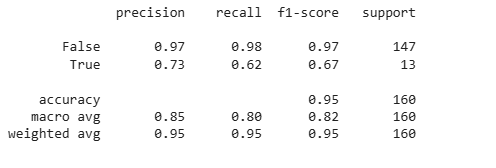


# STEP 4. Comparison and Analysis

In [ ]:
# 데이터 준비
# 인풋과 라벨 설정
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation',
            'name_count','long_name', 'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']
target = "Legendary"

X = pokemon[features]
y = pokemon[target]

# 데이터 분할 (훈련: 80%, 테스트: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 재현성을 위해 랜덤 시드 고정

# 표준화 (SVM 및 로지스틱 회귀에 필요)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 리스트
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
}

# 모델 학습 및 평가
results = {}
for name, model in models.items():
    print(f"Training {name}...")

    if name in ["Logistic Regression", "SVM"]:  # 표준화된 데이터 사용
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# 정확도 비교
print("Model Performance Comparison")
for model, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {acc:.4f}")


# STEP 5. Report

각 모델의 정확도를 비교해서 어떤 모델이 Legendary 포켓몬을 가장 잘 분류하는지 확인하고,  평가 결과는 classification_report로 받아보았다.  

리포트는 네 가지 항목에서 결과를 반환한다.  

    - 정밀도(Precision): 모델이 예측한 Legendary 중 실제로 Legendary인 비율  
    - 재현율(Recall): 실제 Legendary 중 모델이 Legendary로 예측한 비율  
    - F1 점수(F1-Score): 정밀도와 재현율의 조화 평균. 두 지표의 균형을 고려한 성능 평가  
    - 지원도(Support): 클래스별로 실제 레이블의 수  

모델별 정확도는 다음과 같다.  

    Logistic Regression: 0.9812
    Gradient Boosting: 0.9812
    XGBoost: 0.9750
    SVM: 0.9688
    Random Forest: 0.9563

정확도에서 Logistic Regression과 Gradient Boosting이 가장 높은 성능을 보였으며,   둘 다 약 98.12%의 정확도를 보인다. XGBoost와 SVM(96.88%)이 그 뒤를 따르고 있다.

---  
세부 평가 지표에서 정밀도, 재현율, F1 점수에 대해 각 모델이 약간씩 다른 성향을 보인다.



In [ ]:
# 각 모델에 따른 Accuracy 와 F1 score 지표 비교
models = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost']
accuracies = [0.9812, 0.9688, 0.9563, 0.9812, 0.9750]
f1_scores = [0.92, 0.84, 0.80, 0.93, 0.90]  # F1 점수는 각 모델의 macro avg에서 가져옴

# 데이터프레임으로 변환
data = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})

# 시각화
plt.figure(figsize=(10, 6))

# 모델별 정확도와 F1 점수를 바 비교
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(data, id_vars=['Model'], value_vars=['Accuracy', 'F1 Score']),
            palette="Blues_d")

# 제목과 라벨 설정
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Metric', loc='upper left')

# 그래프 출력
plt.tight_layout()
plt.show()
